In [34]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pickle




In [35]:
housing = pd.read_csv("../data/raw/09_housing_california.csv")
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### Seleccion de variables

In [36]:
X = housing [["Latitude", "Longitude", "MedInc"]].copy()
X.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   20640 non-null  float64
 1   Longitude  20640 non-null  float64
 2   MedInc     20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


In [38]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
Longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
MedInc,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001


#### Distribuciones

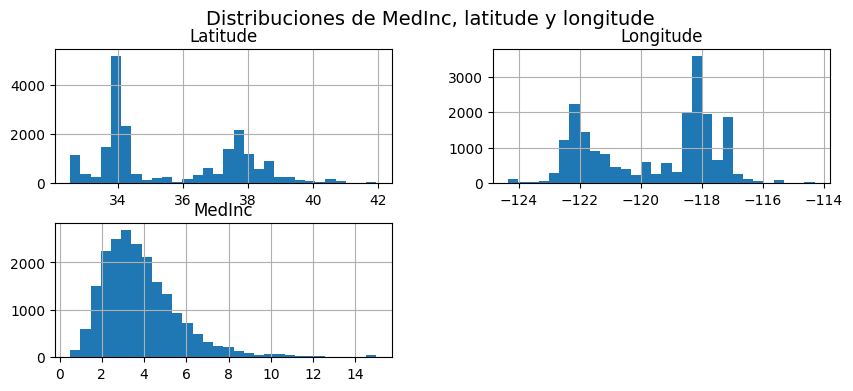

In [39]:
X.hist(figsize=(10,4), bins=30)
plt.suptitle("Distribuciones de MedInc, latitude y longitude", fontsize=14)
plt.show()

#### Correlación

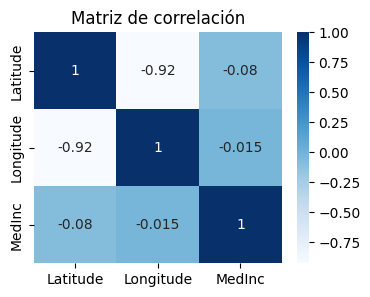

In [40]:
plt.figure(figsize=(4,3))
sns.heatmap(X.corr(), annot=True, cmap="Blues")
plt.title("Matriz de correlación")
plt.show()

Los histogramas nos muestran que latitud y longitudse agrupan en zonas especificas mostrando la distribución de California. MedInc está sesgada hacia valores bajos con una escala distinta, por lo que será necesario normalizar.

La correlación revela que latitud y longitud están muy relacionadas, mientras que MedInc no presenta relación con ninguna de las anteriores. Esto puede indicar que KMeans podrá encontrar diferencias combinando ubicación e ingresos.

#### Train-Test Split

In [41]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_test.shape

((16512, 3), (4128, 3))

#### Escalado

Antes de entrenar el modelo K-Means, es fundamental escalar las variables para que todas trabajen en la misma magnitud, ya que cada punto contiene un vector de las tres variables y al no estar normalizadas la que tenga mayor rango dominará la distancia y cada una se encuentra en rangos completamente diferentes.

In [42]:
X.head(1)

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252


Además, al escalar con el conjunto de entrenamiento (`fit_transform` *Train* y `transform` en test), evitamos fugas de información y garantizamos que los nuevos datos se procesen con las misma escala que la que utilizaremos para entrenar el modelo

In [43]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.01702128, 0.72908367, 0.19032151],
       [0.12978723, 0.61653386, 0.22845202],
       [0.22446809, 0.38545817, 0.25216204],
       [0.01489362, 0.72111554, 0.09948828],
       [0.45      , 0.45318725, 0.21063847]])

### K-means

En este proyecto utilizamos **K-Means** para agrupar viviendas de California según su latitud, longitud en ingreso medio. Aunque en el código no especificaremos la forma de inicialización de los centroides es importante destacar  que **Sklearn** utiliza por defecto el método `k-means++`, incluso si no lo especificamos explícitamente.
`k-means++`, es una estrategia que selecciona los centroides iniciales de forma que evita que comiencen a calcular agrupados en una misma zona reduciendo así el riesgo de obtener soluciones pobres. Esto es importante en este ejercicio, porque los datos contienen patrones geograficos claros (zonas costeras, zonas interiores, niveles de ingresos diferentes). Una mala inicialización podría llevar a a clusteres poco coherentes.


#### Método del codo 

Antes de entrenar el modelo en cuestión, es necesario decidir cuántos clusteres (k) utilizaremos. Aunque el proyecto nos sugiere *k=6*, aplicaremos el método del codo (*Elbow method*), que consiste en entrenar el modelo con distintos valores de **k** y registrar la *inercia*, que no es más que la suma de distancias de cada punto a su centroide. La *inercia* disminuye a medida que aumentamos el número de clústeres, pero llega a unm punto que esa reducción deja de ser significativa . Ese punto marca el "codo" y nos ayuda a elegir un valor adecuado de **k**.
 

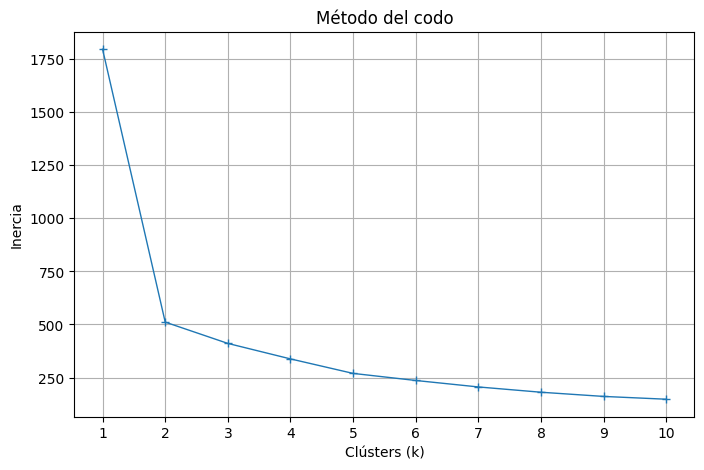

In [44]:
inertias = []
K_values = range(1,11) # prueba de clústers 1-10

for k in K_values:
    kmeans_temp = KMeans(n_clusters=k,
                         n_init=10, #centroides iniciales "k-means++" 
                         random_state=42)
    kmeans_temp.fit(X_train_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_values, inertias, "+-", linewidth=1)
plt.xlabel("Clústers (k)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.xticks(K_values)
plt.grid(True)
plt.show()

En el caso de nuestras 3 variables del dataset *housing_california*, la curva del codo empieza a estabilizarse alrededor de *k=5* o *k=6*, lo cual coincide con lo indicado en el proyecto.
Por otra parte, el parametro `n_init=10` hace que **K_Means** se ejecute 10 veces con distintas inicializaciones basadas en *k_means++*, seleccionando automaticamente la solución con menor inercia. Esto significa que el proceso del método del codo no solo evalúa diferentes valores de K, sino que también asegura de comparar versiones estables del modelo.

Entrenar K_Means en K=6 y asignación de cluster

In [45]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans.fit(X_train_scaled)
train_clusters = kmeans.labels_#obtención del número de clúster al que pertenece cada punto del conjunto de entrenamiento
train_clusters

array([2, 2, 4, ..., 2, 0, 3], shape=(16512,), dtype=int32)

Crear columna cluster en el conjunto para visualizar la asignación

In [46]:
train_with_clusters = X_train.copy()
train_with_clusters["cluster"] = train_clusters
train_with_clusters.head()


,Latitude,Longitude,MedInc,cluster
14196,32.71,-117.03,3.2596,2
8267,33.77,-118.16,3.8125,2
17445,34.66,-120.48,4.1563,4
14265,32.69,-117.11,1.9425,2
2271,36.78,-119.80,3.5542,4


#### Visualización de clusters (solo train)
Tres vistas:
* Lat vs Lon  
* Lat vs MedInc  
* Lon vs MedInc  

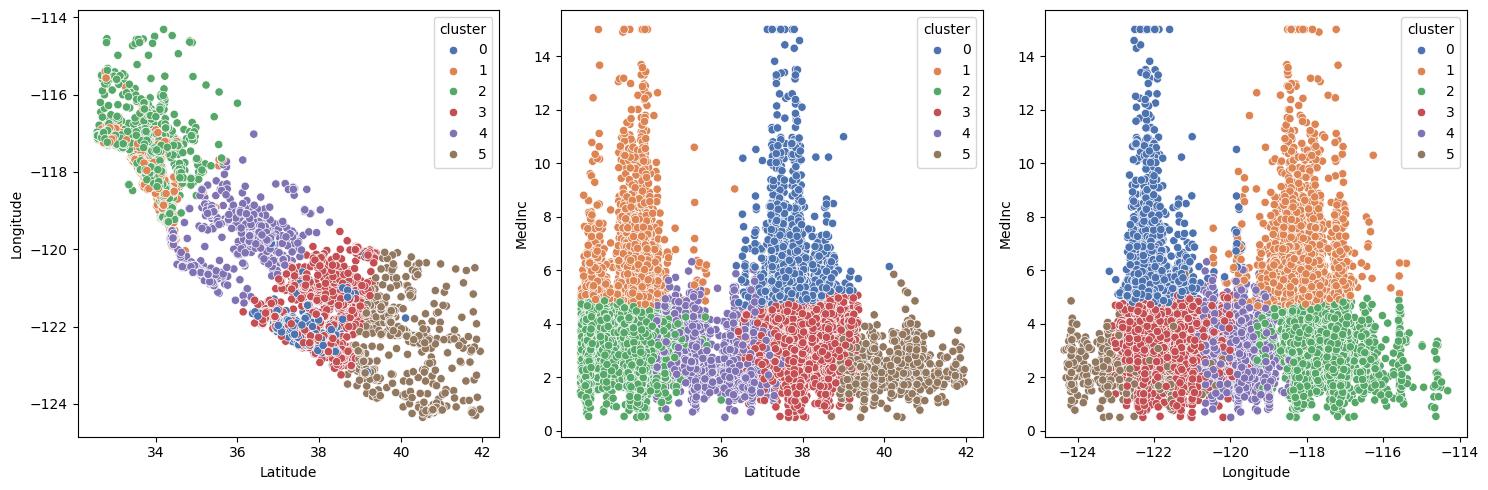

In [47]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(ax=axis[0],
                data=train_with_clusters,
                x="Latitude",
                y="Longitude",
                hue="cluster",
                palette="deep")

sns.scatterplot(ax=axis[1],
                data=train_with_clusters,
                x="Latitude",
                y="MedInc",
                hue="cluster",
                palette="deep")

sns.scatterplot(ax=axis[2],
                data=train_with_clusters,
                x="Longitude",
                y="MedInc",
                hue="cluster",
                palette="deep")

plt.tight_layout()
plt.show()


#### Predicción de clusters en el test

In [48]:
test_clusters = kmeans.predict(X_test_scaled)

test_with_clusters = X_test.copy()
test_with_clusters["cluster"] = test_clusters
test_with_clusters.head()


,Latitude,Longitude,MedInc,cluster
20046,36.06,-119.01,1.6812,4
3024,35.14,-119.46,2.5313,4
15663,37.80,-122.44,3.4801,3
20484,34.28,-118.72,5.7376,1
9814,36.62,-121.93,3.7250,3


#### Gráfico train vs test

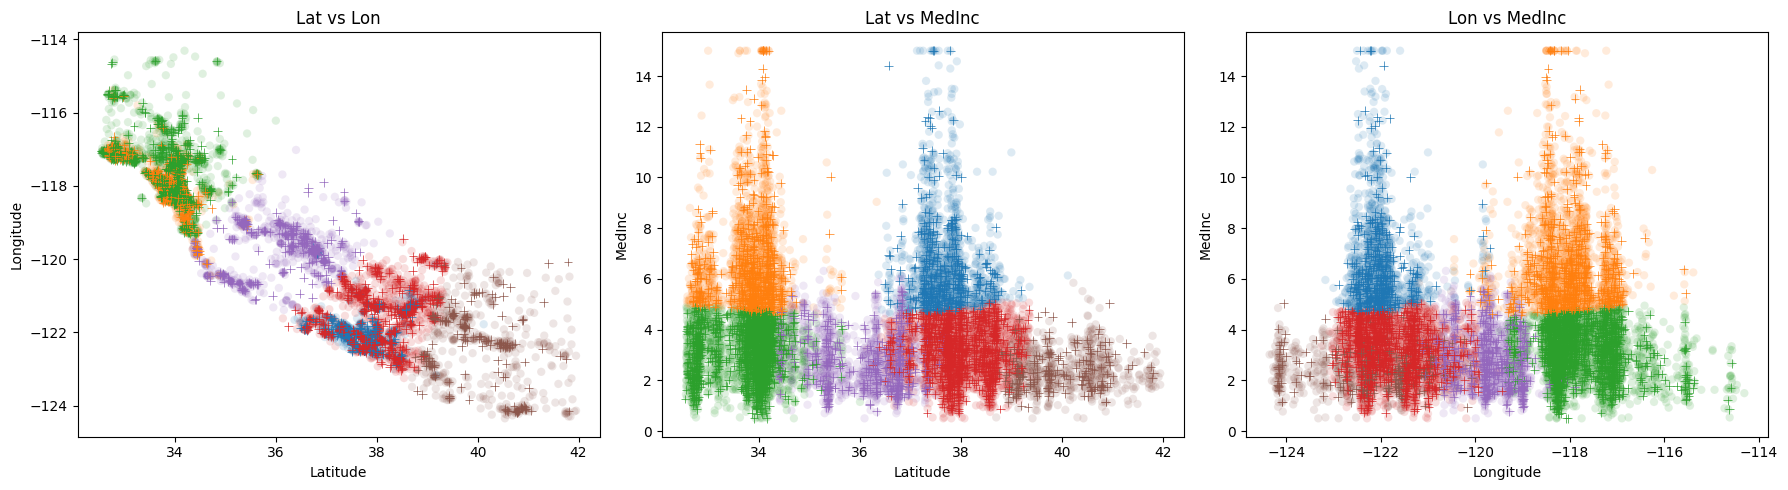

In [49]:
fig, axis = plt.subplots(1, 3, figsize=(18, 5))

# Latitude vs Longitude
sns.scatterplot(ax=axis[0],
                data=train_with_clusters,
                x="Latitude",
                y="Longitude",
                hue="cluster",
                palette="tab10",
                alpha=0.15,
                legend=False)

sns.scatterplot(ax=axis[0],
                data=test_with_clusters,
                x="Latitude",
                y="Longitude",
                hue="cluster",
                palette="tab10",
                marker="+",
                s=40,
                legend=False)
axis[0].set_title("Lat vs Lon")

# Latitude vs MedInc
sns.scatterplot(ax=axis[1],
                data=train_with_clusters,
                x="Latitude",
                y="MedInc",
                hue="cluster",
                palette="tab10",
                alpha=0.15,
                legend=False)

sns.scatterplot(ax=axis[1],
                data=test_with_clusters,
                x="Latitude",
                y="MedInc",
                hue="cluster",
                palette="tab10",
                marker="+",
                s=40,
                legend=False)

axis[1].set_title("Lat vs MedInc")

# Longitude vs MedInc
sns.scatterplot(ax=axis[2],
                data=train_with_clusters,
                x="Longitude",
                y="MedInc",
                hue="cluster",
                palette="tab10",
                alpha=0.15,
                legend=False)

sns.scatterplot(ax=axis[2],
                data=test_with_clusters,
                x="Longitude",
                y="MedInc",
                hue="cluster",
                palette="tab10",
                marker="+",
                s=40,
                legend=False)
axis[2].set_title("Lon vs MedInc")

plt.tight_layout()
plt.show()


En estos gráficos los puntos del train aparecen como fondo suave y los puntos de test como cruces. Al compararlos podemos ver que las cruces caen en las mismas zonas que en las de fondo suave, Esto significa que K-means a agrupado bien los datos.

#### Modelo supervisado con random forest

Para realizar el modelo supervisado construimos un conjunto de datos a partir del resultado de K-Means

In [50]:
X_train_sup = X_train_scaled
y_train_sup = train_clusters #etiquetas que creo K-means

X_test_sup = X_test_scaled
y_test_sup = test_clusters

In [51]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_sup, y_train_sup)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Evaluación

In [52]:
y_pred_sup = rf_clf.predict(X_test_sup)

In [53]:
accuracy_score(y_test_sup, y_pred_sup)

0.9953972868217055

In [54]:
report_dicc = classification_report(y_test_sup, y_pred_sup, output_dict=True)
df = pd.DataFrame(report_dicc).transpose()
df

,precision,recall,f1-score,support
0,0.989101,0.991803,0.990450,366.000000
1,0.996616,0.994932,0.995773,592.000000
2,0.998223,0.998814,0.998519,1687.000000
3,0.990779,0.995881,0.993323,971.000000
4,0.996988,0.993994,0.995489,333.000000
5,1.000000,0.972067,0.985836,179.000000
accuracy,0.995397,0.995397,0.995397,0.995397
macro avg,0.995284,0.991249,0.993232,4128.000000
weighted avg,0.995410,0.995397,0.995393,4128.000000


In [55]:
confusion_matrix(y_test_sup, y_pred_sup)

array([[ 363,    0,    0,    3,    0,    0],
       [   0,  589,    2,    0,    1,    0],
       [   0,    2, 1685,    0,    0,    0],
       [   4,    0,    0,  967,    0,    0],
       [   0,    0,    1,    1,  331,    0],
       [   0,    0,    0,    5,    0,  174]])

El modelo Random Forest (supervisado), lo hemos entrenado para aprender a predecir el cluster asignado por **K-means** usando los datos escalados. Se puede observar un resultado casi perfecto. Una accuracy de 0.995, es decir, casi todas las predicciones coinciden con los clusteres, las diferentes métricas como recall f1-score y precisión obtienen valores muy altos, lo que indica que identifica correctamente los clusteres y en la matriz de confusión casi no hay errores. Resumiendo, Random Forest generaliza muy bien y es capaz de predecir el cluster de nuevas viviendas con una gran fiabilidad.

#### Guardado del modelo

In [57]:
with open("../models/09_kmeans_6clusters.pkl", "wb") as f:
    pickle.dump(kmeans, f)